## Import data from Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import helper


data_dir = '/content/drive/MyDrive/artwork-data/'

In [ ]:
# check for GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Dec  7 21:36:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [ ]:
# Image augmentation

# TRAIN Sets
transform_train_default = transforms.Compose([
                                transforms.Resize(750),
                                transforms.CenterCrop(750),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
                                ])
transform_train_vflip = transforms.Compose([
                                transforms.Resize(750),
                                transforms.CenterCrop(750),
                                transforms.RandomVerticalFlip(p=1),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
                                ])
transform_train_jitter = transforms.Compose([
                                transforms.Resize(750),
                                transforms.CenterCrop(750),
                                transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0, hue=0),
                                transforms.ToTensor()
                                ])
transform_train_gaussian = transforms.Compose([
                                transforms.Resize(750),
                                transforms.CenterCrop(750),
                                transforms.ToTensor(),
                                AddGaussianNoise(0.1, 0.08)
                                ])
transform_train_crop = transforms.Compose([
                                transforms.Resize(1000),
                                transforms.RandomCrop(750),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
                                ])
# TEST Set
transform_test = transforms.Compose([
                                transforms.Resize(750),
                                transforms.CenterCrop(750),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
                                ])

dataset_train_default = datasets.ImageFolder(data_dir + 'images/images', transform=transform_train_default)
dataset_train_vflip = datasets.ImageFolder(data_dir + 'images/images', transform=transform_train_vflip)
dataset_train_jitter = datasets.ImageFolder(data_dir + 'images/images', transform=transform_train_jitter)
dataset_train_gaussian = datasets.ImageFolder(data_dir + 'images/images', transform=transform_train_gaussian)
dataset_train_crop = datasets.ImageFolder(data_dir + 'images/images', transform=transform_train_crop)
dataset_train = torch.utils.data.ConcatDataset((dataset_train_default, dataset_train_vflip, dataset_train_jitter, dataset_train_gaussian, dataset_train_crop))

dataset_test = datasets.ImageFolder(data_dir + 'images/images', transform=transform_test)

In [ ]:
len(dataset_train)

42230

In [ ]:
# Classes
classes_train, classes_test = dataset_train_default.classes, dataset_test.classes
classes = classes_train
len(classes_train), len(classes_test)

(50, 50)

### Split into train and test

In [ ]:
# train test split
test_size = 0.1

# initialize counter
class_counter = [0] * 50

for idx, (path, artist_class) in enumerate(dataset_train_default.imgs):
  class_counter[artist_class] += 1

train_idx, test_idx = [], []
aggregate = 0
train_len = len(dataset_train_default)

for class_count in class_counter:
  split = int(np.floor(test_size * class_count))
  indices = list(range(class_count))
  train_idx_local, test_idx_local = indices[split:aggregate], indices[:split]

  # Get the indeces for all the training data, the original and the augmented images
  train_idx_tuples = [(x + aggregate, train_len + x + aggregate, 2 * train_len + x + aggregate, 3 * train_len + x + aggregate, 4 * train_len + x + aggregate) for x in train_idx_local]
  train_idx += [i for sub in train_idx_tuples for i in sub]
  
  # Get the indeces for the test images
  test_idx += [x + aggregate for x in test_idx_local]
  aggregate += class_count

print(len(train_idx), len(test_idx))

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

36645 821


In [ ]:
print(test_idx)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 780, 781, 782, 783, 784, 785, 786, 787, 788, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1151, 1152, 1153, 1154, 1155, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1360, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524

## Load images

In [ ]:
batch_size = 24

In [ ]:
train_dataloader = torch.utils.data.DataLoader(
  dataset_train, batch_size=batch_size, sampler=train_sampler,
  num_workers=2
)
test_dataloader = torch.utils.data.DataLoader(
  dataset_test, batch_size=batch_size, sampler=test_sampler,
  num_workers=2
)

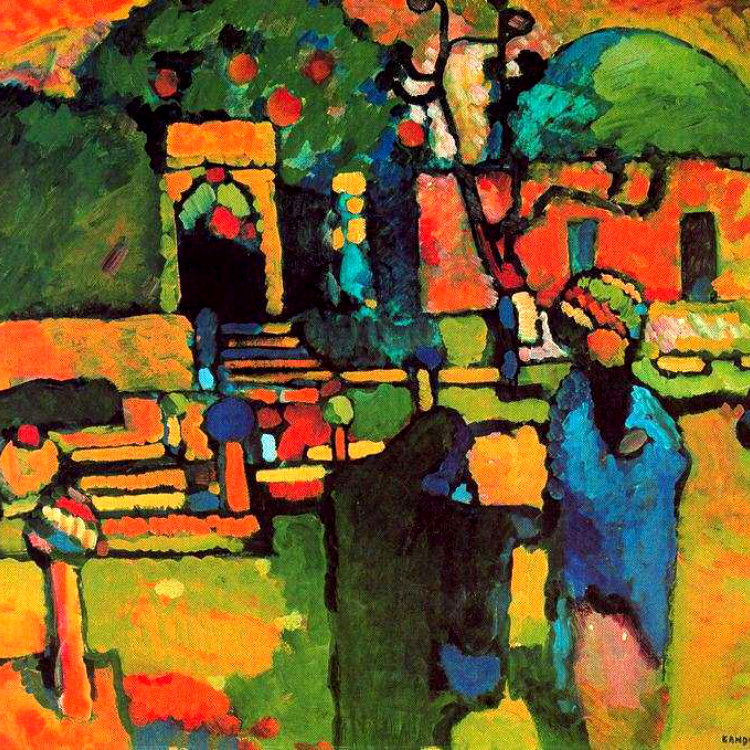

In [ ]:
# Display an example image
images, labels = next(iter(train_dataloader))
transforms.functional.to_pil_image(images[15])

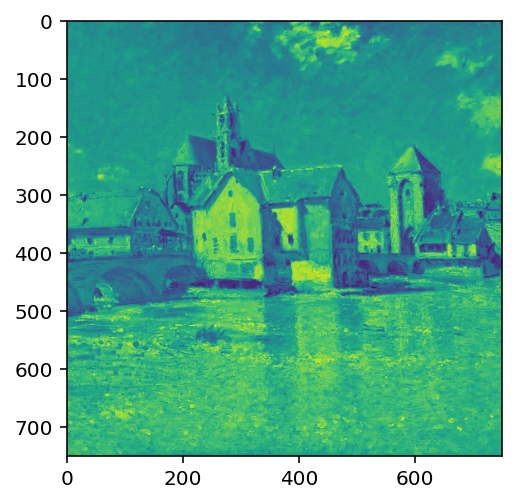

The label of the image is: 1


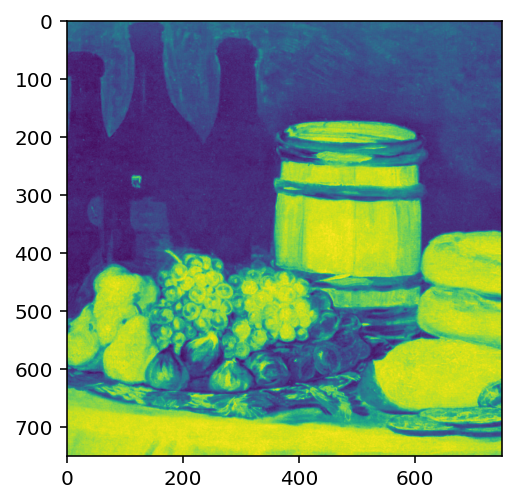

The label of the image is: 15


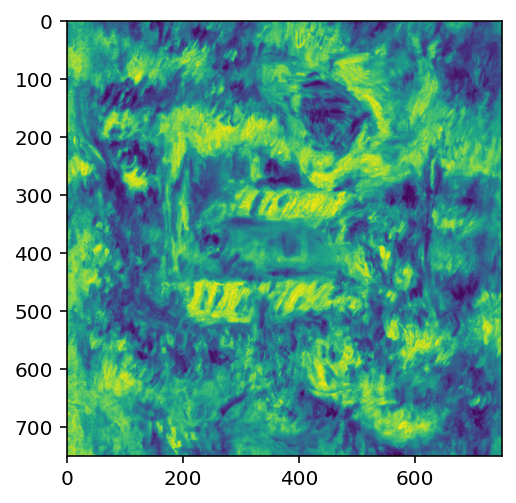

The label of the image is: 38


In [ ]:
import random

# Print the Image using Matplotlib
rand_numer1 = random.randint(0,25338)
plt.imshow(dataset_train[rand_numer1][0][0])
plt.show()
print("The label of the image is:", dataset_train[rand_numer1][1])

rand_numer2 = random.randint(0,25338)
plt.imshow(dataset_train[rand_numer2][0][0])
plt.show()
print("The label of the image is:", dataset_train[rand_numer2][1])

rand_numer3 = random.randint(0,25338)
plt.imshow(dataset_train[rand_numer3][0][0])
plt.show()
print("The label of the image is:", dataset_train[rand_numer3][1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


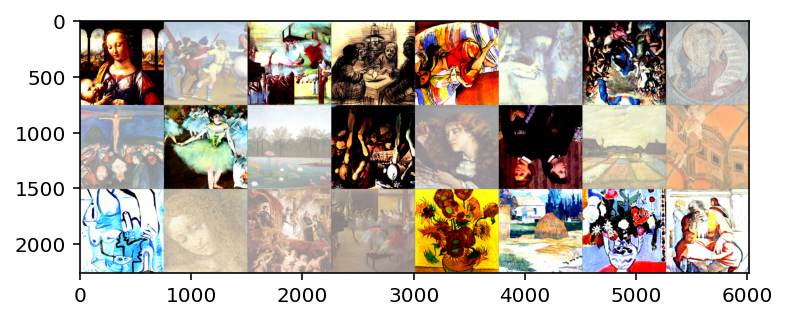

Leonardo_da_Vinci Raphael Edgar_Degas Vincent_van_Gogh


In [ ]:
batch_size = 4
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
data_iter = iter(train_dataloader)
images, labels = data_iter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## Import artists

In [5]:
artists = pd.read_csv(data_dir + '/artists.csv')
artists.shape

(50, 8)

In [6]:
artists.sort_values(by='paintings').head()

id  ... paintings
49  49  ...        24
39  39  ...        31
41  41  ...        43
38  38  ...        47
48  48  ...        49

[5 rows x 8 columns]

## Load a neural network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# x = torch.randn(64,3,100,100)
# print(net(x).shape)

Load pretrained CNN

In [ ]:
# Empty cuda cache
torch.cuda.empty_cache()

In [ ]:
# net = torchvision.models.resnet18(pretrained=True)
net = torch.hub.load('pytorch/vision:v0.11.0', 'resnet34', pretrained=True)
# net = torchvision.models.vgg16(pretrained=True)
net = net.cuda() if torch.device else net

Downloading: "https://github.com/pytorch/vision/archive/v0.11.0.zip" to /root/.cache/torch/hub/v0.11.0.zip
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

## Define a Loss function and Optimizer

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

## Train the network

In [ ]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_dataloader):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(torch.device('cuda')))
        loss = criterion(outputs, labels.to(torch.device('cuda')))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 0.5)
        optimizer.step() 

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

print('Finished Training')

[1,    10] loss: 8.565
[1,    20] loss: 8.114
[1,    30] loss: 7.369
[1,    40] loss: 6.726
[1,    50] loss: 6.109
[1,    60] loss: 5.448
[1,    70] loss: 4.980
[1,    80] loss: 4.388
[1,    90] loss: 4.224
[1,   100] loss: 4.238
[1,   110] loss: 3.963
[1,   120] loss: 3.841
[1,   130] loss: 3.518
[1,   140] loss: 3.661
[1,   150] loss: 3.703
[1,   160] loss: 3.390
[1,   170] loss: 3.245
[1,   180] loss: 3.332
[1,   190] loss: 3.247
[1,   200] loss: 2.948
[1,   210] loss: 2.912
[1,   220] loss: 2.747
[1,   230] loss: 2.960
[1,   240] loss: 2.647
[1,   250] loss: 2.874
[1,   260] loss: 2.680
[1,   270] loss: 2.396
[1,   280] loss: 2.609
[1,   290] loss: 2.461
[1,   300] loss: 2.447
[1,   310] loss: 2.411
[1,   320] loss: 2.402
[1,   330] loss: 2.198
[1,   340] loss: 2.348
[1,   350] loss: 2.187
[1,   360] loss: 2.256
[1,   370] loss: 2.196
[1,   380] loss: 2.433
[1,   390] loss: 2.200
[1,   400] loss: 2.225
[1,   410] loss: 2.234
[1,   420] loss: 2.166
[1,   430] loss: 1.825
[1,   440] 

In [ ]:
# Save the model
PATH = './model.pth'
torch.save(net.state_dict(), PATH)

Test the network

In [ ]:
data_iter = iter(test_dataloader)
images, labels = data_iter.next()

# print images
transforms.functional.to_pil_image(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

GroundTruth:  Frida_Kahlo Leonardo_da_Vinci Vincent_van_Gogh Vincent_van_Gogh


In [ ]:
# Load training model from file

# net = torch.hub.load('pytorch/vision:v0.11.0', 'resnet34', pretrained=True)
net.load_state_dict(torch.load(data_dir + '/final_model.pth'))

<All keys matched successfully>

In [ ]:
outputs = net(images.to(torch.device('cuda')))

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  Paul_Gauguin Amedeo_Modigliani Francisco_Goya Pieter_Bruegel


### Accuracy

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images.to(torch.device('cuda')))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(torch.device('cuda'))).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 79 %


### Accuracy by class

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = net(images.to(torch.device('cuda')))
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels.to(torch.device('cuda')), predictions):
          if label == prediction:
              correct_pred[classes[label]] += 1
          # else:
          #   if classes[label] == 'Albrecht_Dürer':
          #     print('incorrect: ', classes[label], '!=', classes[prediction])
          total_pred[classes[label]] += 1


class_accuracies = []

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))
    class_accuracies.append

Accuracy for class Albrecht_Dürer is: 0.0 %
Accuracy for class Alfred_Sisley is: 88.0 %
Accuracy for class Amedeo_Modigliani is: 89.5 %
Accuracy for class Andrei_Rublev is: 77.8 %
Accuracy for class Andy_Warhol is: 94.4 %
Accuracy for class Camille_Pissarro is: 66.7 %
Accuracy for class Caravaggio is: 80.0 %
Accuracy for class Claude_Monet is: 28.6 %
Accuracy for class Diego_Rivera is: 85.7 %
Accuracy for class Diego_Velazquez is: 100.0 %
Accuracy for class Edgar_Degas is: 97.1 %
Accuracy for class Edouard_Manet is: 66.7 %
Accuracy for class Edvard_Munch is: 66.7 %
Accuracy for class El_Greco is: 87.5 %
Accuracy for class Eugene_Delacroix is: 33.3 %
Accuracy for class Francisco_Goya is: 69.0 %
Accuracy for class Frida_Kahlo is: 91.7 %
Accuracy for class Georges_Seurat is: 100.0 %
Accuracy for class Giotto_di_Bondone is: 72.7 %
Accuracy for class Gustav_Klimt is: 54.5 %
Accuracy for class Gustave_Courbet is: 60.0 %
Accuracy for class Henri_Matisse is: 94.4 %
Accuracy for class Henri_Ro

In [ ]:
classes_plot = []
accuracy_plot = []

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    
    classes_plot.append(classname)
    accuracy_plot.append(accuracy)

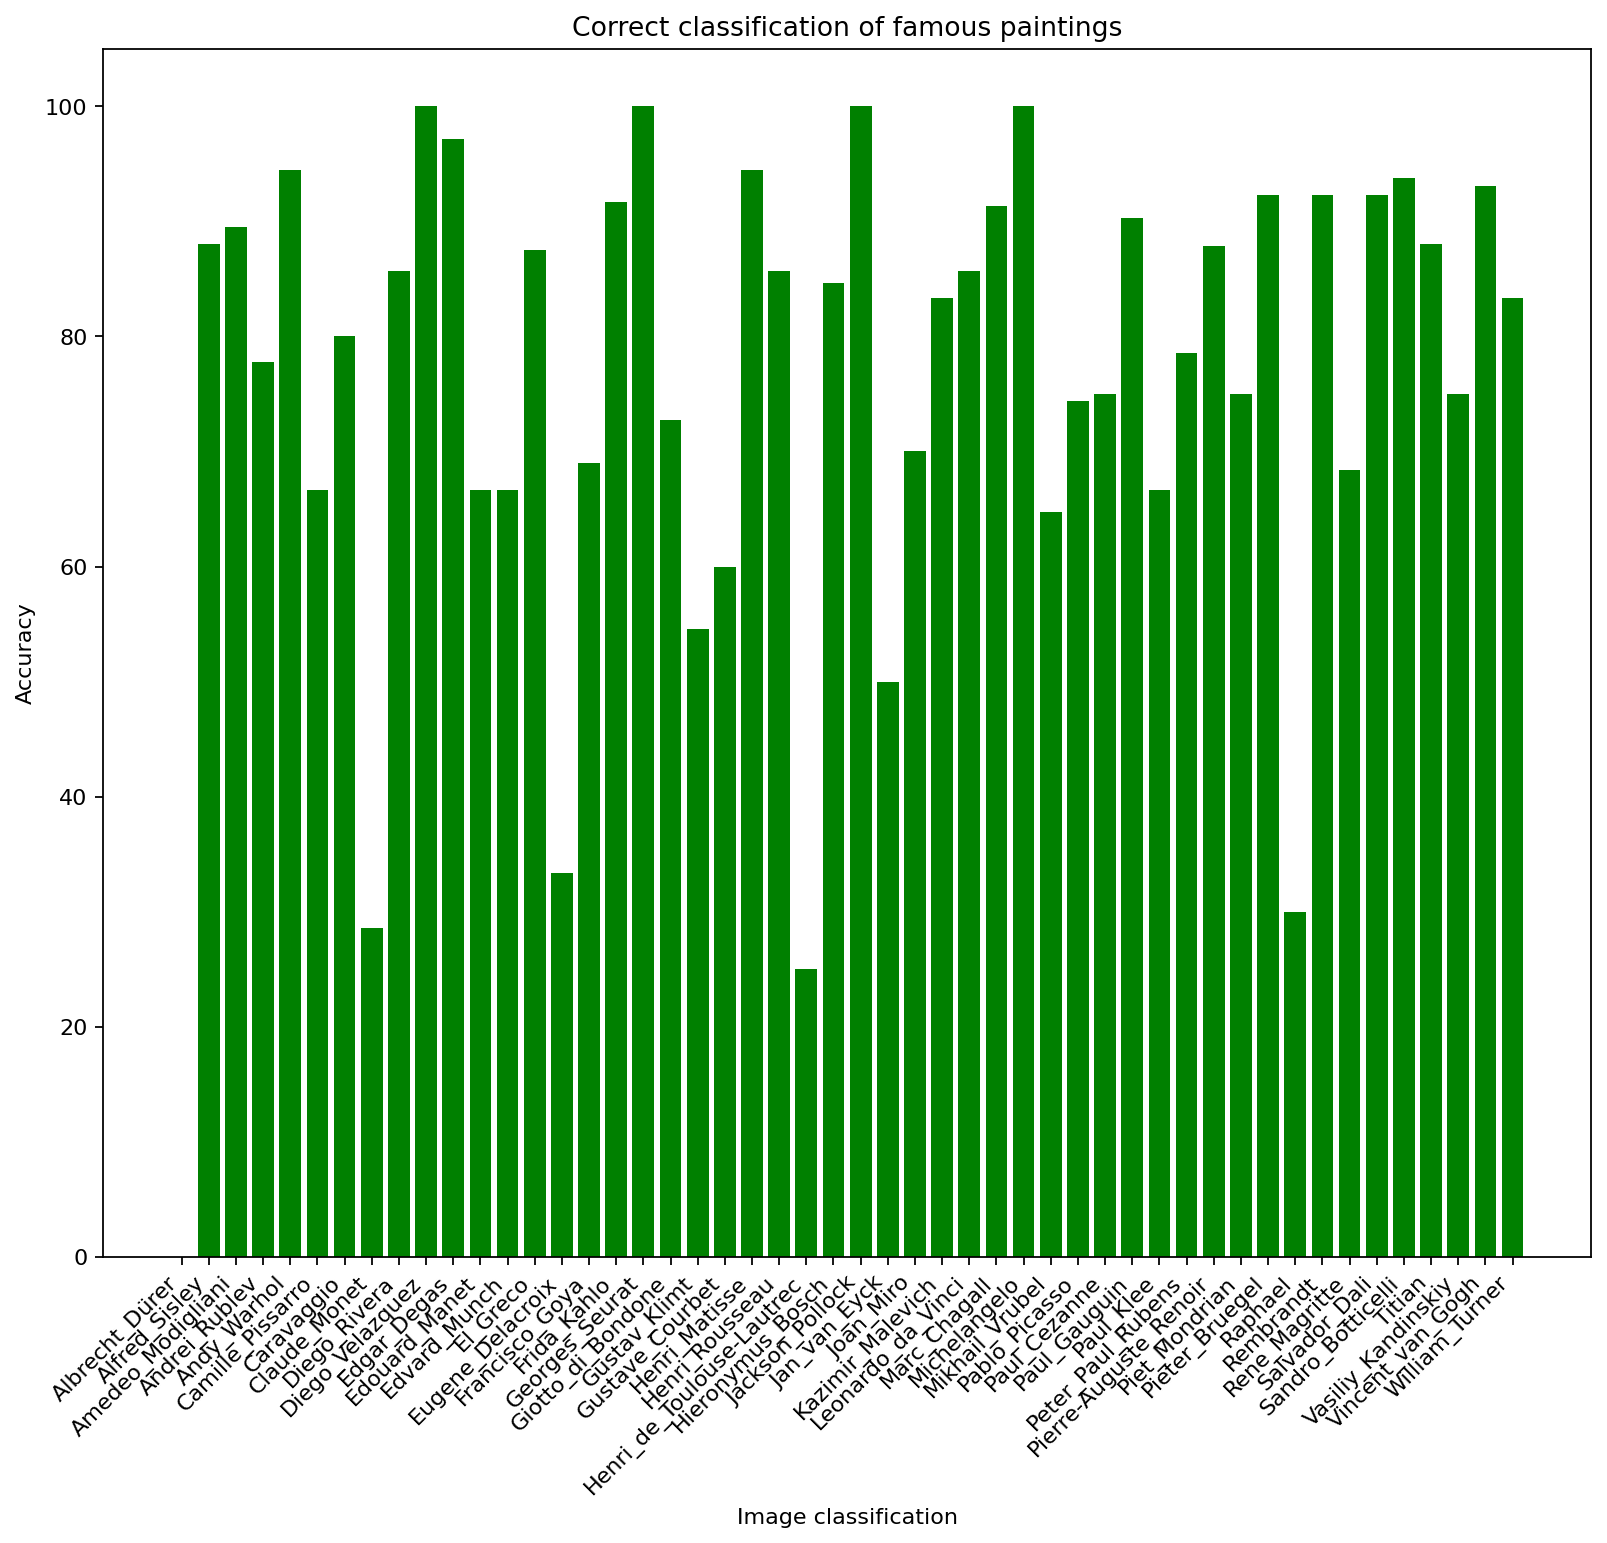

In [ ]:
# Artist accuracy bar plot

from matplotlib.pyplot import figure

figure(figsize=(12, 10), dpi=80)

x_pos = [i for i, _ in enumerate(classes_plot)]

plt.bar(x_pos, accuracy_plot, color='green')
plt.xlabel("Image classification")
plt.ylabel("Accuracy")
plt.title("Correct classification of famous paintings")

plt.xticks(x_pos, classes_plot)
plt.xticks(rotation=45, ha="right")

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


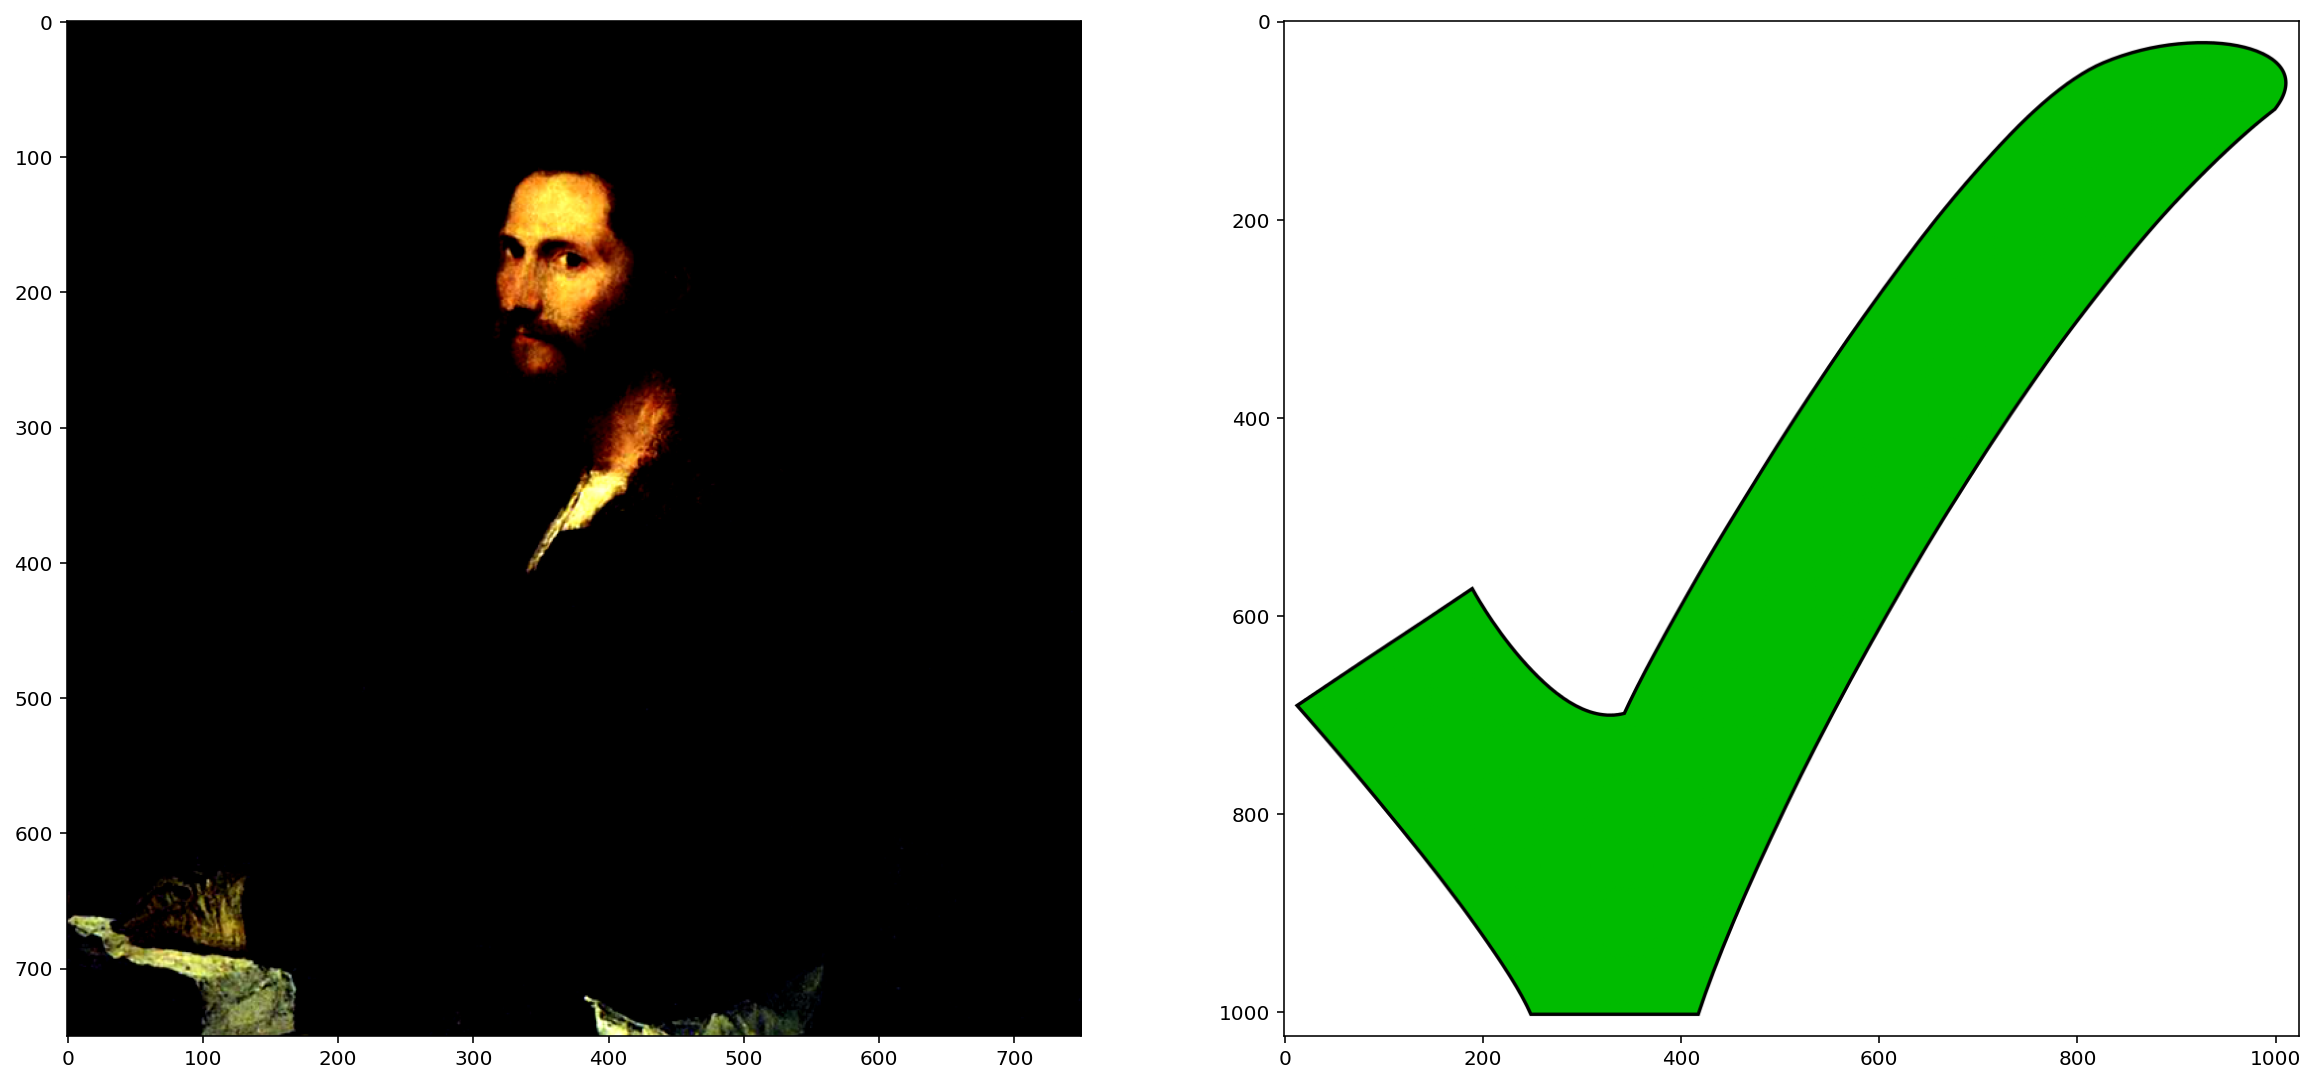

The label of the image is: Titian
The prediction of the image is: Titian 




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


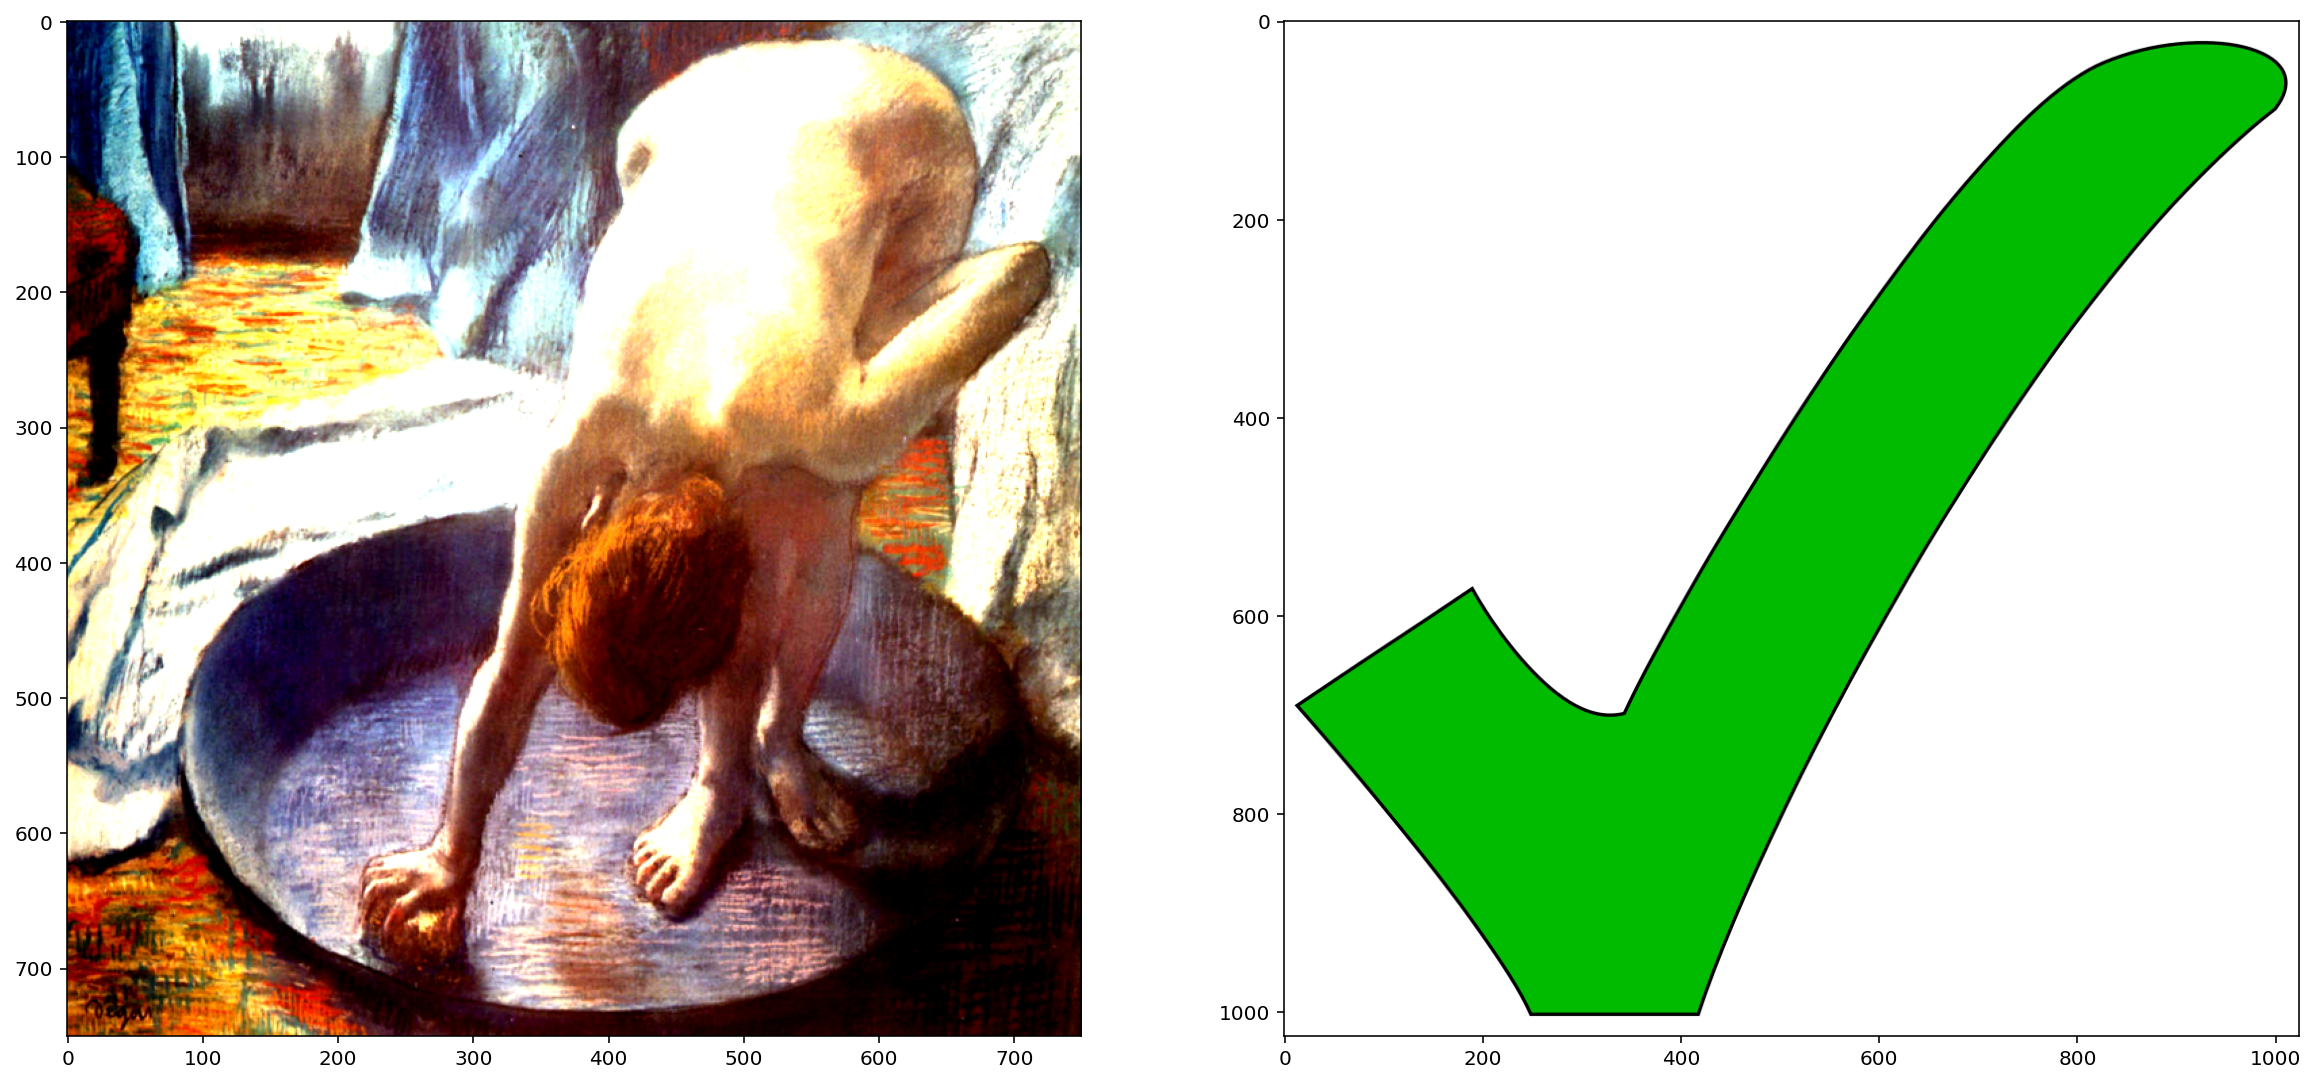

The label of the image is: Edgar_Degas
The prediction of the image is: Edgar_Degas 




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


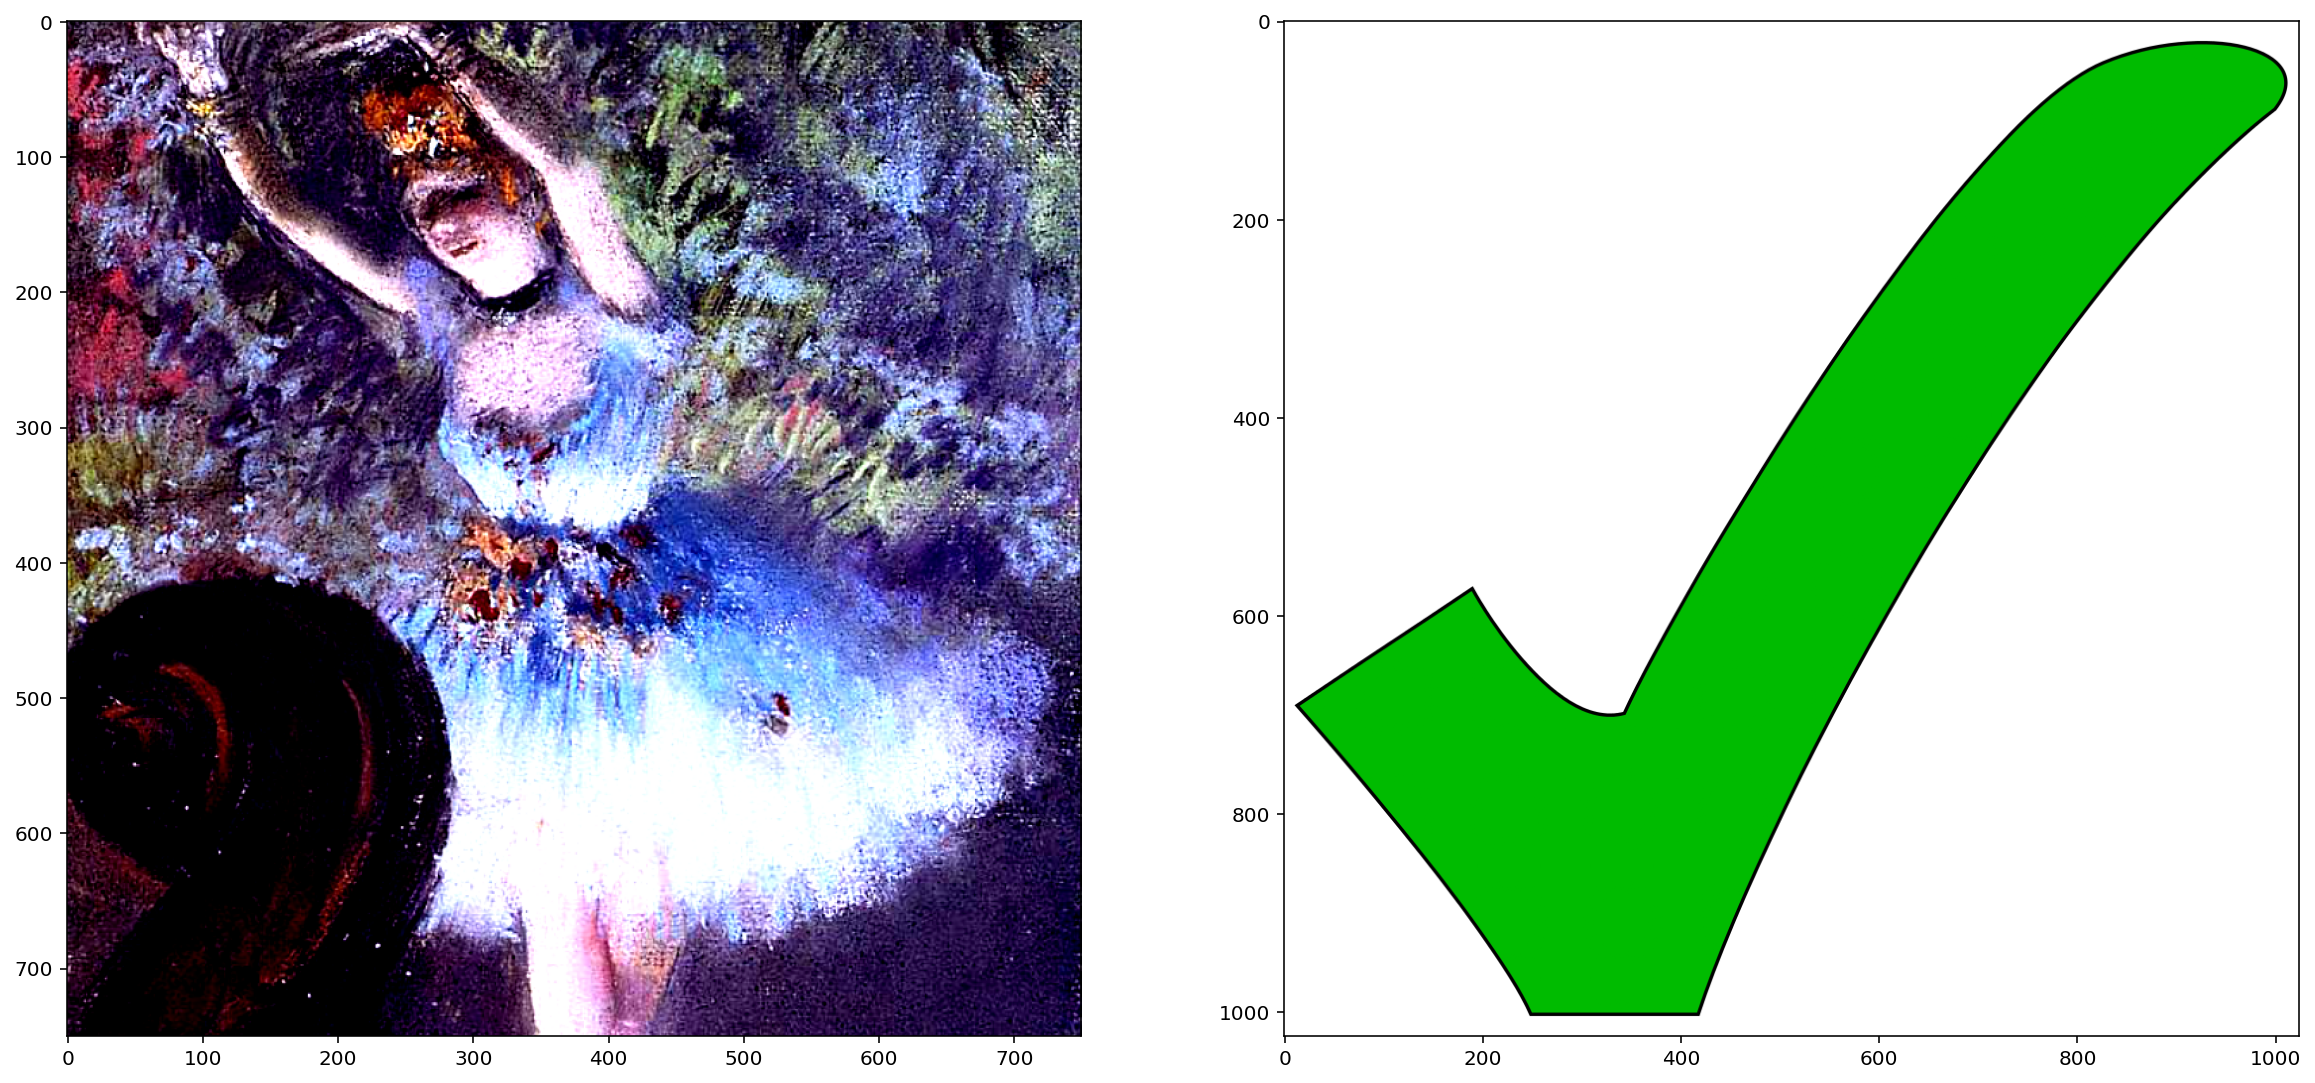

The label of the image is: Edgar_Degas
The prediction of the image is: Edgar_Degas 




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


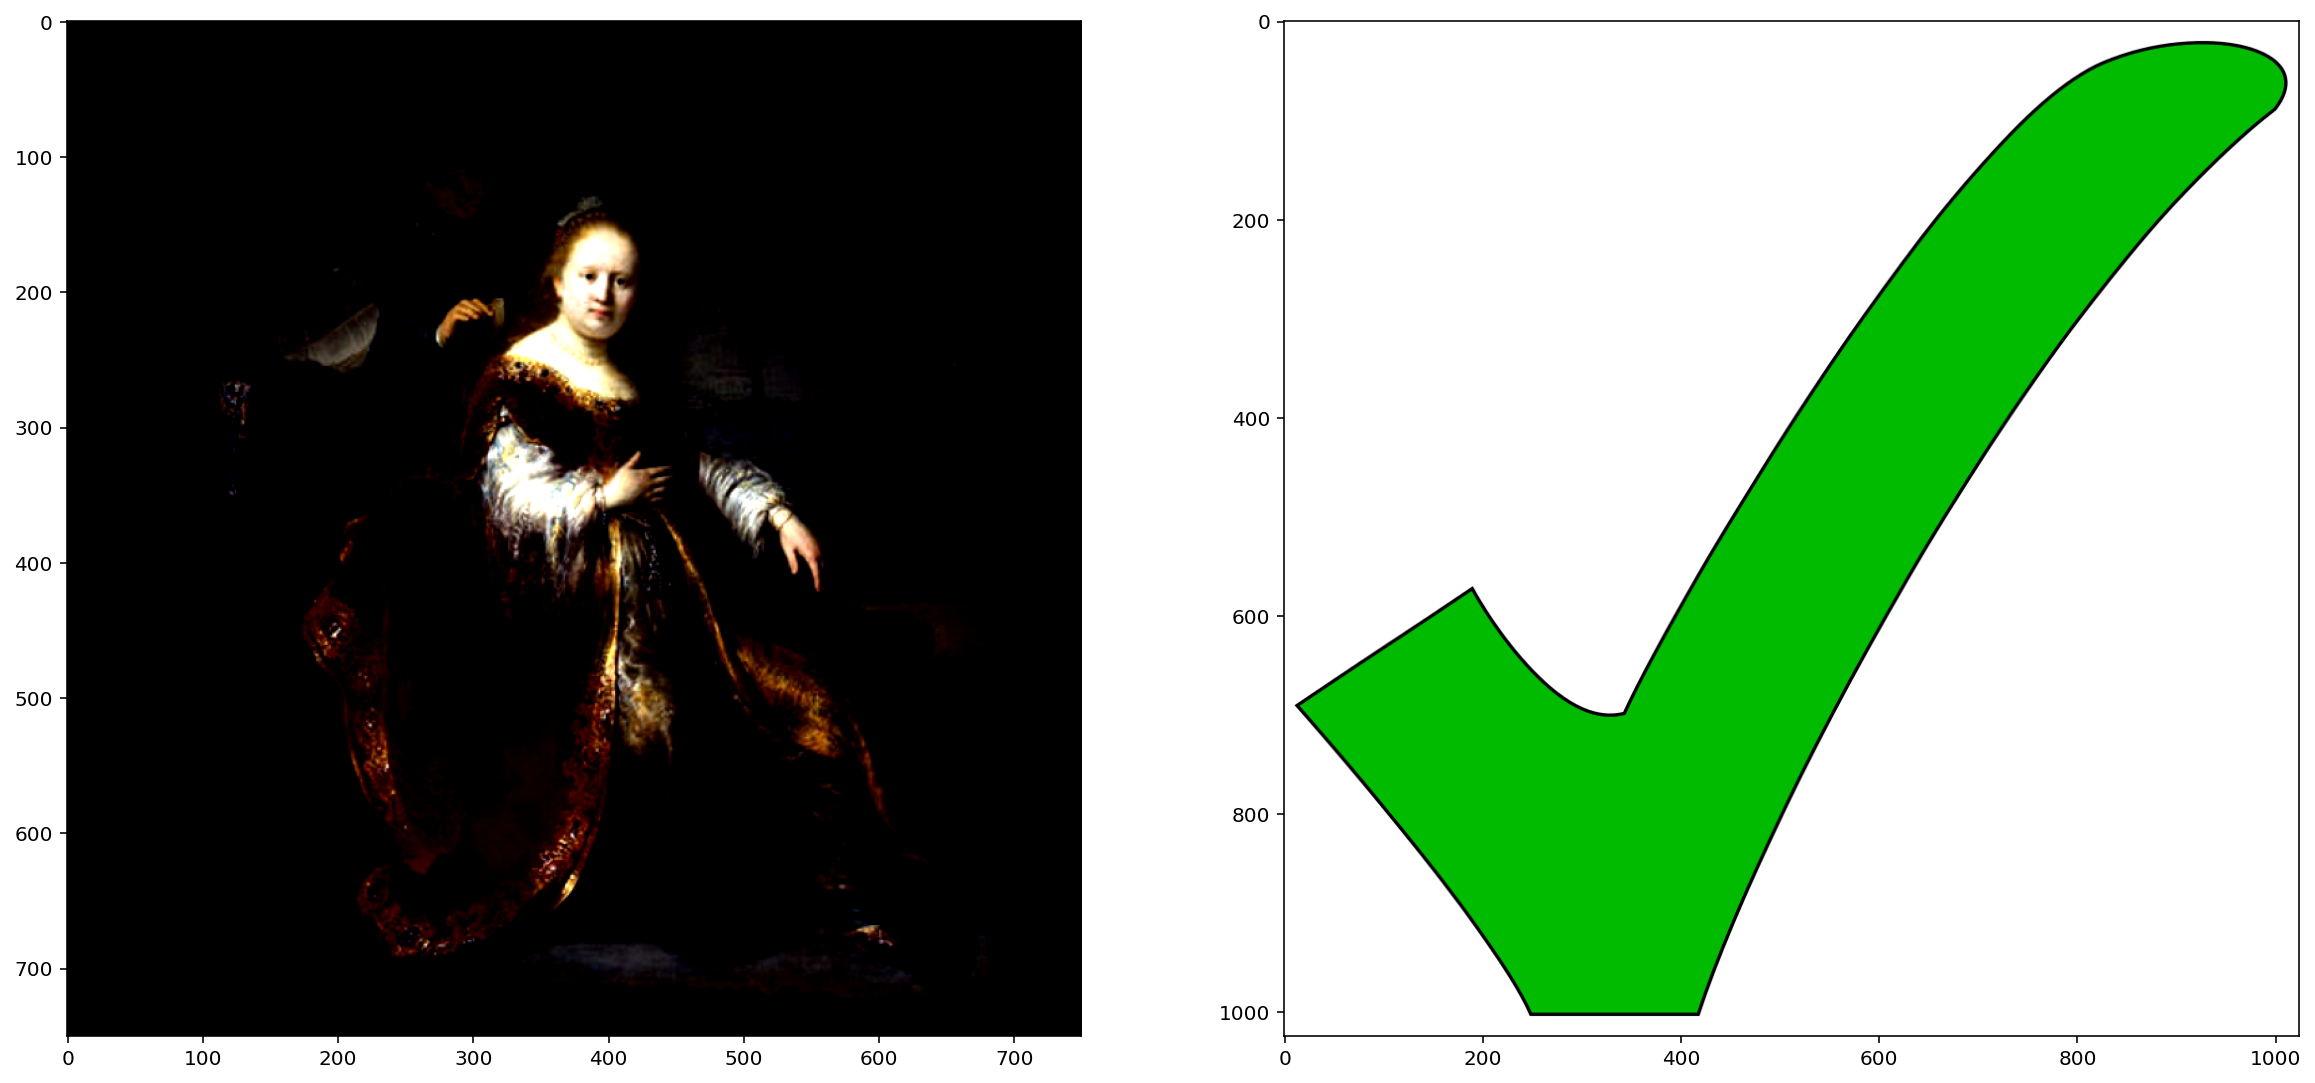

The label of the image is: Rembrandt
The prediction of the image is: Rembrandt 




In [ ]:
import matplotlib.image as mpimg

def imshow(img, ax):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))

# DEMO
with torch.no_grad():
    for idx, data in enumerate(test_dataloader):
        images, labels = data
        outputs = net(images.to(torch.device('cuda')))
        _, predictions = torch.max(outputs, 1)

        if idx == 5 or idx == 10 or idx == 20 or idx == 30:
          f, axes = plt.subplots(1, 2, figsize=(20, 10))
          imshow(images[1], axes[0])
          
          if classes[labels[1]] == classes[predictions[1]]:
            axes[1].imshow(mpimg.imread(data_dir + '/green-tick.svg.png'))
          else:
            axes[1].imshow(mpimg.imread(data_dir + '/red-x.svg.png'))
          
          plt.show()
          print("The label of the image is:", classes[labels[1]])
          print("The prediction of the image is:", classes[predictions[1]], "\n\n")

